In [245]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [246]:
gstock_data = pd.read_csv('/content/BTC_USD.csv')
gstock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3595,2024-07-21,67164.914063,68372.906250,65842.296875,68154.523438,68154.523438,2.665219e+10
3596,2024-07-22,68152.976563,68480.062500,66611.296875,67585.250000,67585.250000,4.264911e+10
3597,2024-07-23,67584.804688,67779.015625,65484.460938,65927.671875,65927.671875,3.560567e+10
3598,2024-07-24,NaN,NaN,NaN,NaN,NaN,NaN
3599,2024-07-25,65370.265625,65588.679688,63904.535156,64255.671875,64255.671875,3.471387e+10


In [248]:
# Select relevant columns and format date
gstock_data = gstock_data[['Date', 'Open', 'Close']]
gstock_data['Date'] = pd.to_datetime(gstock_data['Date'].apply(lambda x: x.split()[0]))
gstock_data.set_index('Date', drop=True, inplace=True)
print(gstock_data.tail())


                    Open         Close
Date                                  
2024-07-21  67164.914063  68154.523438
2024-07-22  68152.976563  67585.250000
2024-07-23  67584.804688  65927.671875
2024-07-24           NaN           NaN
2024-07-25  65370.265625  64255.671875


<ipython-input-248-05c8ba294484>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gstock_data['Date'] = pd.to_datetime(gstock_data['Date'].apply(lambda x: x.split()[0]))


In [249]:
# # Calculate EMAs
# gstock_data['EMA12'] = gstock_data['Close'].ewm(span=12, adjust=False).mean()
# gstock_data['EMA26'] = gstock_data['Close'].ewm(span=26, adjust=False).mean()

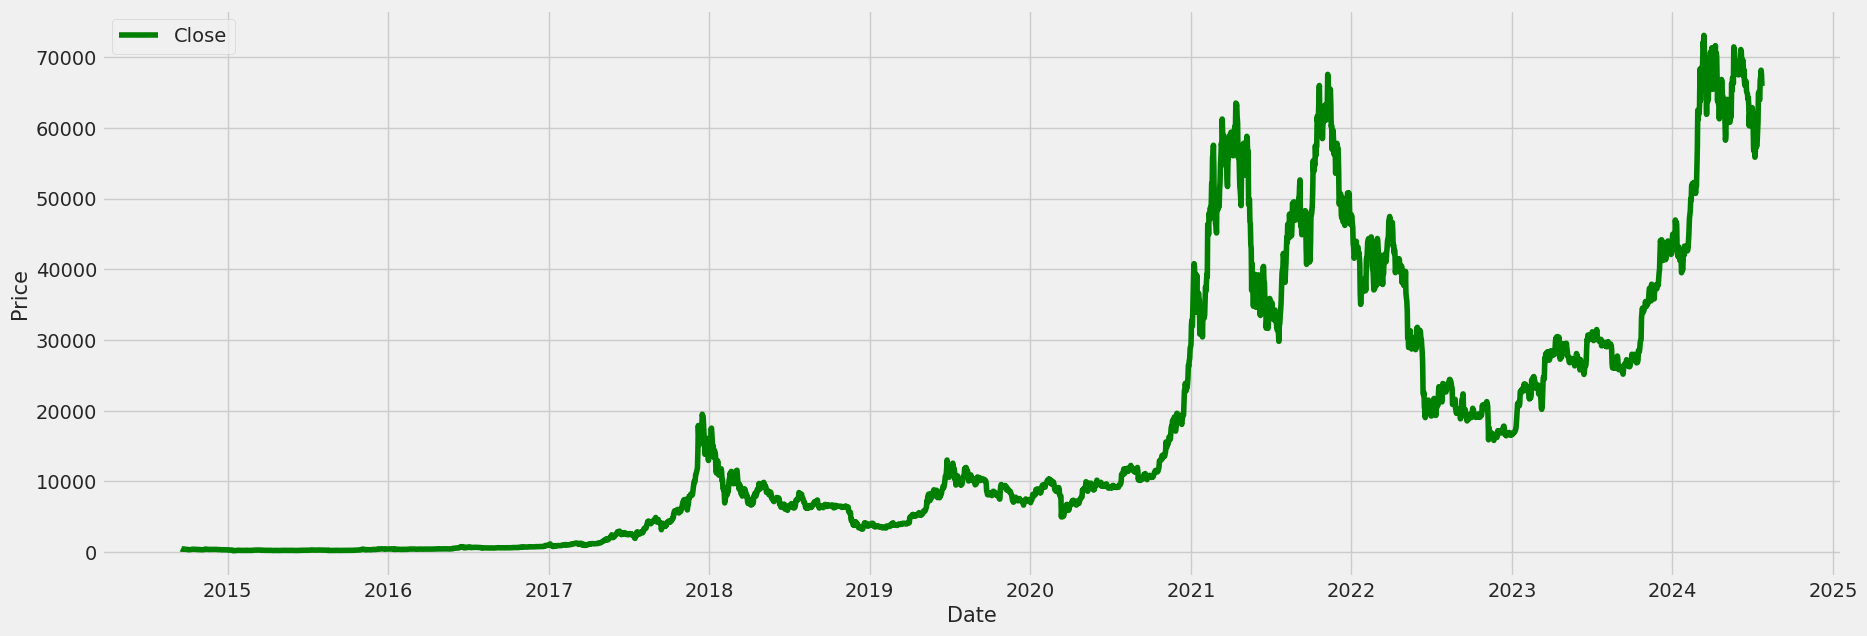

In [251]:
# Plot the data
fig, ax = plt.subplots(1, figsize=(20, 7))

ax.plot(gstock_data['Close'], label='Close', color='green')
ax.set_xlabel('Date', size=15)
ax.set_ylabel('Price', size=15)
# ax.plot(gstock_data['EMA12'], label='EMA12', color='blue')
# ax.plot(gstock_data['EMA26'], label='EMA26', color='orange')
ax.legend()



In [252]:
Ms = MinMaxScaler()
gstock_data [gstock_data .columns] = Ms.fit_transform(gstock_data )

training_size = round(len(gstock_data ) * 0.80)

train_data = gstock_data [:training_size]
test_data  = gstock_data [training_size:]

In [253]:
print(len(train_data))
print(len(test_data))

2880
720
                Open     Close
Date                          
2022-08-06  0.317061  0.312503
2022-08-07  0.312563  0.315447
2022-08-08  0.315526  0.324138
2022-08-09  0.324195  0.315288
2022-08-10  0.315298  0.326033


In [254]:
def create_sequence(dataset):
    sequences = []
    labels = []
    start_idx = 0

    for stop_idx in range(100, len(dataset)):
        sequences.append(dataset.iloc[start_idx:stop_idx])
        labels.append(dataset.iloc[stop_idx])
        start_idx += 1

    return np.array(sequences), np.array(labels)

# Create sequences
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [255]:
print(train_seq.shape)
print(train_label.shape)
print(test_seq.shape)
print(test_label.shape)

(2780, 100, 2)
(2780, 2)
(620, 100, 2)
(620, 2)


In [256]:
# Define the model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(train_seq.shape[1], train_seq.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dense(train_label.shape[1]))  # Adjust the output units to match the number of features in labels

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Print the model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100, 100)          41200     
                                                                 
 dropout_9 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_19 (LSTM)              (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 121802 (475.79 KB)
Trainable params: 121802 (475.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [257]:
model.fit(train_seq, train_label, epochs=50,validation_data=(test_seq, test_label), verbose=1)
test_predicted = model.predict(test_seq)


Epoch 1/50
87/87 [==============================] - 33s 255ms/step - loss: 0.0034 - mean_absolute_error: 0.0277 - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/50
87/87 [==============================] - 15s 172ms/step - loss: 7.2104e-04 - mean_absolute_error: 0.0139 - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/50
87/87 [==============================] - 15s 168ms/step - loss: 6.2577e-04 - mean_absolute_error: 0.0131 - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/50
87/87 [==============================] - 15s 170ms/step - loss: 5.7317e-04 - mean_absolute_error: 0.0127 - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/50
87/87 [==============================] - 15s 171ms/step - loss: 5.5312e-04 - mean_absolute_error: 0.0128 - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/50
87/87 [==============================] - 15s 173ms/step - loss: 6.2213e-04 - mean_absolute_error: 0.0138 - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/50
87/87 [========

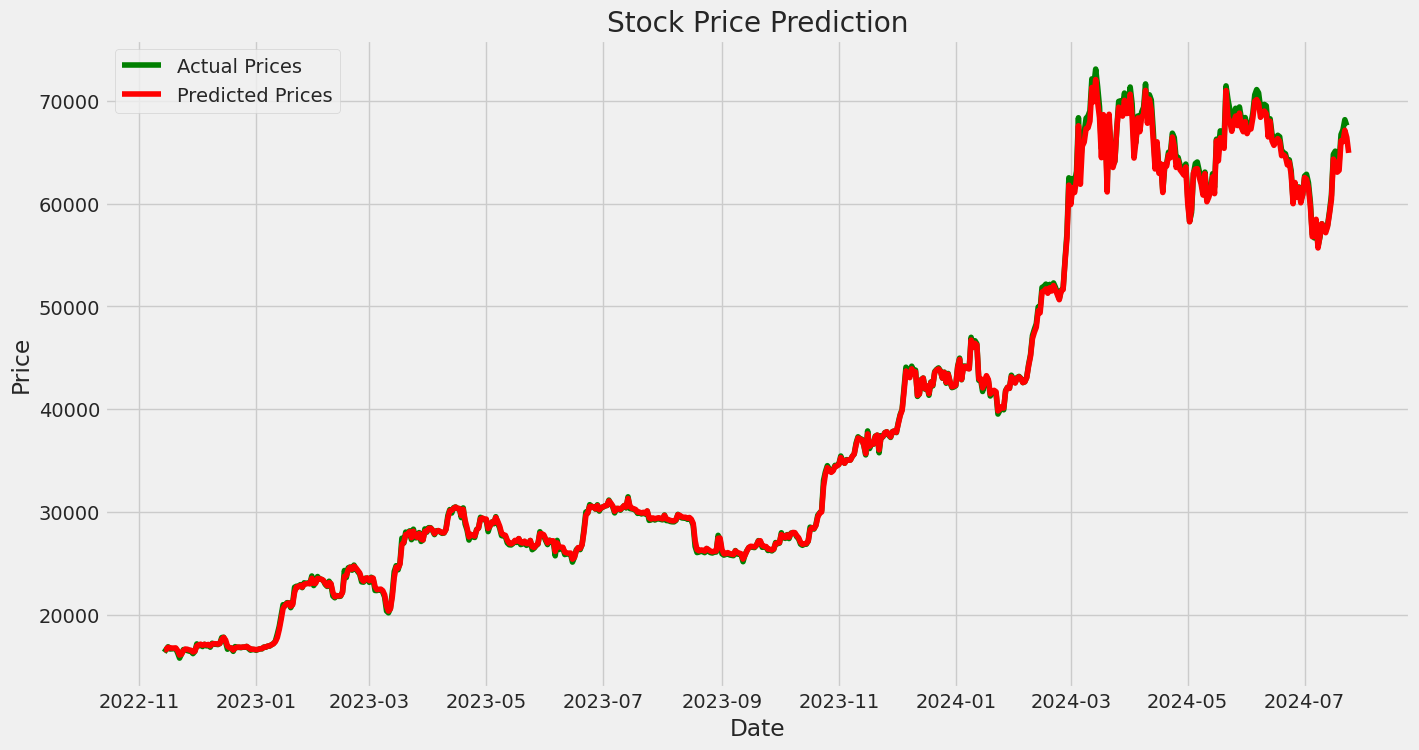

In [258]:

# Assuming 'test_predicted' contains the model's predictions on the test set

# Invert the scaling to get actual prices
test_predicted_inverted = Ms.inverse_transform(test_predicted)
test_labels_inverted = Ms.inverse_transform(test_label)

# Plot the training data, actual prices, and predicted prices
plt.figure(figsize=(15, 8))

# Plot actual prices
plt.plot(gstock_data.index[training_size + 100:], test_labels_inverted[:, 0], label='Actual Prices', color='green')  # Assuming 'Close' is at index 0

# Plot predicted prices
plt.plot(gstock_data.index[training_size + 100:], test_predicted_inverted[:, 0], label='Predicted Prices', color='red')  # Assuming 'Close' is at index 0

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()


In [259]:
# Calculate MAPE for each day, handle division by zero or NaN values
mape_per_day = np.abs((test_labels_inverted[:, 0] - test_predicted_inverted[:, 0]) / test_labels_inverted[:, 0]) * 100

# Skip NaN values
valid_mape_per_day = mape_per_day[~np.isnan(mape_per_day)]

# Calculate overall MAPE
overall_mape = np.mean(valid_mape_per_day)
print(f"\nOverall MAPE: {overall_mape:.2f}%")


Overall MAPE: 0.54%
